# Install

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.4 MB/s eta 0:00:00


# **Imports and Data**

In [2]:
# Importing Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing time series specific libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import kpss

# Libaraies for evaluation of model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from statsmodels.tsa.arima.model import ARIMAResults

# Read CSV file
data = pd.read_csv('productsales.csv')

# **Data Exploration**

In [3]:
data

,stall_id,product_type,date,number_sold
0,0,0,2010-01-01,801
1,0,0,2010-01-02,810
2,0,0,2010-01-03,818
3,0,0,2010-01-04,796
4,0,0,2010-01-05,808
...,...,...,...,...
255635,6,9,2019-12-27,901
255636,6,9,2019-12-28,926
255637,6,9,2019-12-29,913
255638,6,9,2019-12-30,899


In [4]:
data.describe()

,stall_id,product_type,number_sold
count,255640.000000,255640.000000,255640.000000
mean,3.000000,4.500000,781.838077
std,2.000004,2.872287,204.910291
min,0.000000,0.000000,234.000000
25%,1.000000,2.000000,722.000000
50%,3.000000,4.500000,836.000000
75%,5.000000,7.000000,916.000000
max,6.000000,9.000000,1205.000000


In [5]:
data['date']=pd.to_datetime(data['date'], infer_datetime_format=True)
data=data.set_index(['date'])
print(data.head())

            stall_id  product_type  number_sold
date                                           
2010-01-01         0             0          801
2010-01-02         0             0          810
2010-01-03         0             0          818
2010-01-04         0             0          796
2010-01-05         0             0          808


<ipython-input-5-9fa5ae334831>:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['date']=pd.to_datetime(data['date'], infer_datetime_format=True)


In [6]:
# Ensure sorted by date
data = data.sort_values(by='date')

# Preprocessing

In [7]:
# Total sales over time
total_sales  = data.groupby('date')['number_sold'].sum()
total_sales.describe(include = 'all')

count     3652.000000
mean     54728.665389
std        364.921063
min      53943.000000
25%      54451.000000
50%      54700.000000
75%      54939.000000
max      55952.000000
Name: number_sold, dtype: float64

In [8]:
# Calculate total sales by product type
product_sales = data.groupby('product_type')['number_sold'].sum()

# Identify the most and least sold product types
most_sold_product_type = product_sales.idxmax()
least_sold_product_type = product_sales.idxmin()

# Calculate total sales by store (stall id)
store_sales = data.groupby('stall_id')['number_sold'].sum()

# Identify the store with the most and least action figures sold
store_most_sold = store_sales.idxmax()
store_least_sold = store_sales.idxmin()

# Output results
print(f"Most sold product type: {most_sold_product_type}")
print(f"Least sold product type: {least_sold_product_type}")
print(f"Store with the most action figures sold: {store_most_sold}")
print(f"Store with the least action figures sold: {store_least_sold}")

Most sold product type: 7
Least sold product type: 8
Store with the most action figures sold: 4
Store with the least action figures sold: 3


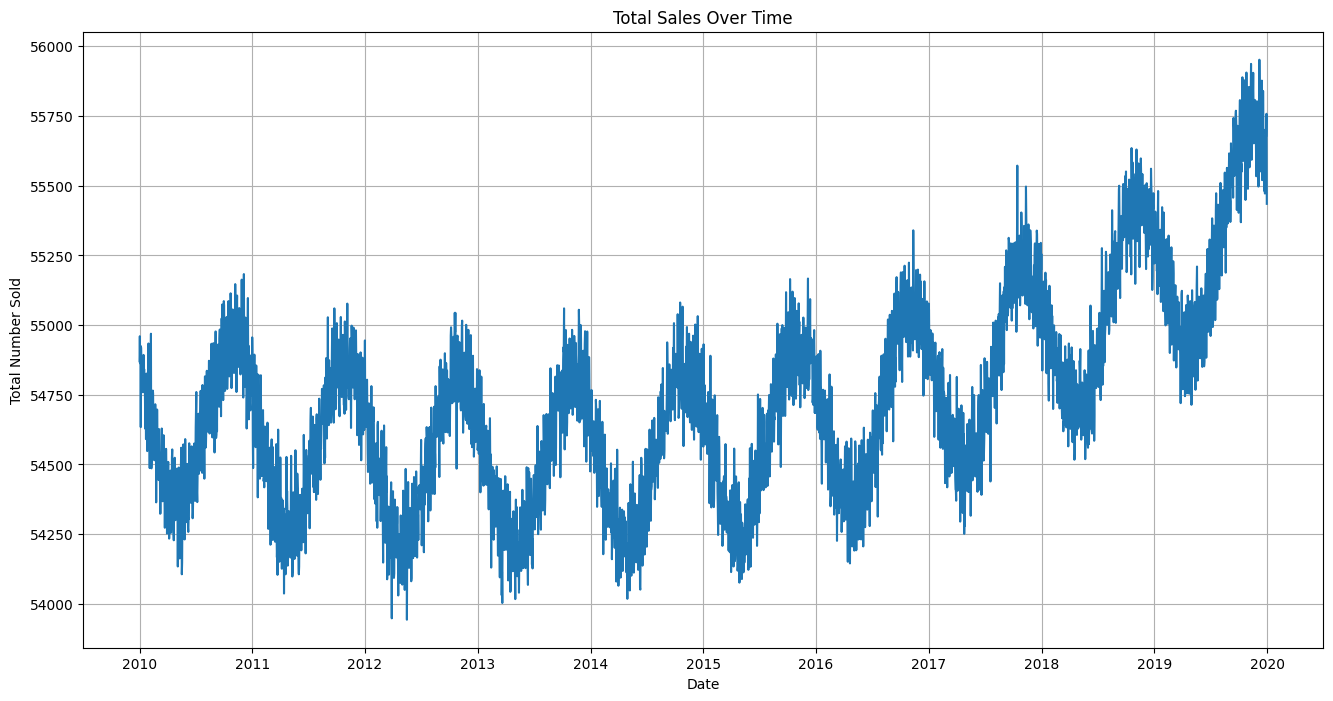

In [9]:
# Plot total sales over time
plt.figure(figsize=(16, 8))
plt.plot(total_sales)
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Number Sold')
plt.grid(True)
plt.show()

# ACF & PACF

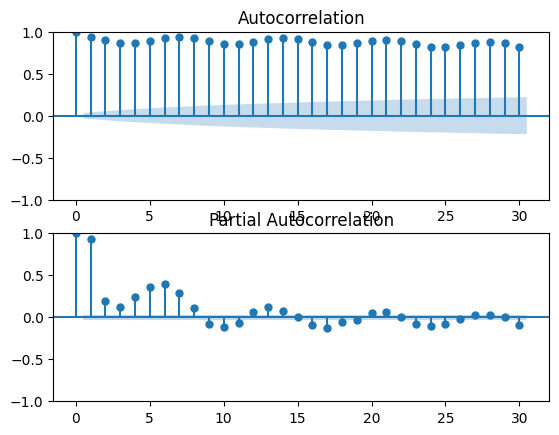

In [10]:
# ACF & PACF Plots
ts = pd.DataFrame(total_sales)

plt.figure()
plt.subplot(211)
plot_acf(ts['number_sold'], ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(ts['number_sold'], ax=plt.gca(), lags = 30)
plt.show()

# Check for Stationarity

In [11]:
# Apply ADF test
adf_result = adfuller(total_sales)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Apply KPSS test
kpss_result = kpss(total_sales, regression='c')
print('\nKPSS Statistic: %f' % kpss_result[0])
print('p-value: %f' % kpss_result[1])
print('Critical Values:')
for key, value in kpss_result[3].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.500075
p-value: 0.115456
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

KPSS Statistic: 4.002083
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


<ipython-input-11-c5e4ed7515cc>:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(total_sales, regression='c')


# Differencing

NOTE: Simple Differencing is applied as I considered the plot as Linear. So wala na ung "period = 1" since for seasonal series ung ganon.

In [12]:
# Apply first differencing
first_difference = total_sales.diff().dropna()

# Apply ADF test on first differenced series
adf_result_diff = adfuller(first_difference)
print('ADF Statistic (First Difference): %f' % adf_result_diff[0])
print('p-value: %f' % adf_result_diff[1])
print('Critical Values:')
for key, value in adf_result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

# Apply KPSS test on first differenced series
kpss_result_diff = kpss(first_difference, regression='c')
print('\nKPSS Statistic (First Difference): %f' % kpss_result_diff[0])
print('p-value: %f' % kpss_result_diff[1])
print('Critical Values:')
for key, value in kpss_result_diff[3].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic (First Difference): -6.985473
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

KPSS Statistic (First Difference): 0.050265
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


<ipython-input-12-20f7a27eb254>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff = kpss(first_difference, regression='c')


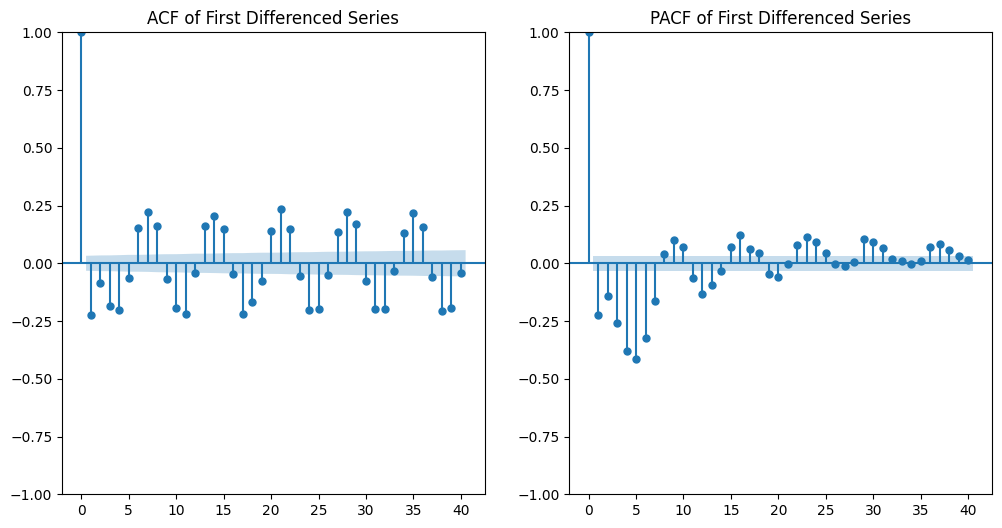

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(first_difference, lags=40, ax=plt.gca())
plt.title('ACF of First Differenced Series')

plt.subplot(122)
plot_pacf(first_difference, lags=40, ax=plt.gca())
plt.title('PACF of First Differenced Series')

plt.show()

# Auto-Arima

In [19]:
# Split the data into training and testing sets based on the specified years
train_data = total_sales[(total_sales.index >= '2010-01-01') & (total_sales.index <= '2018-12-31')]
test_data = total_sales[(total_sales.index >= '2019-01-01') & (total_sales.index <= '2019-12-31')]

# Fit the auto ARIMA model
model = pm.auto_arima(y=train_data)
results = model.fit(y=train_data)
print(results.summary())

# Make predictions on the training set (adjusting for differencing)
start_index = model.order[1]
train_predict = results.predict_in_sample(start=start_index, end=len(train_data)-1)
train_predict_series = pd.Series(train_predict, index=train_data.index[start_index:])

# Make predictions on the test set
predictions = results.predict(n_periods=len(test_data))
predictions_series = pd.Series(predictions, index=test_data.index)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3287
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -19614.589
Date:                Fri, 12 Jul 2024   AIC                          39245.178
Time:                        13:55:18   BIC                          39293.957
Sample:                    01-01-2010   HQIC                         39262.643
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4941      0.019     26.122      0.000       0.457       0.531
ar.L2         -0.5948      0.020    -30.331      0.000      -0.633      -0.556
ar.L3         -0.3186      0.022    -14.758      0.0

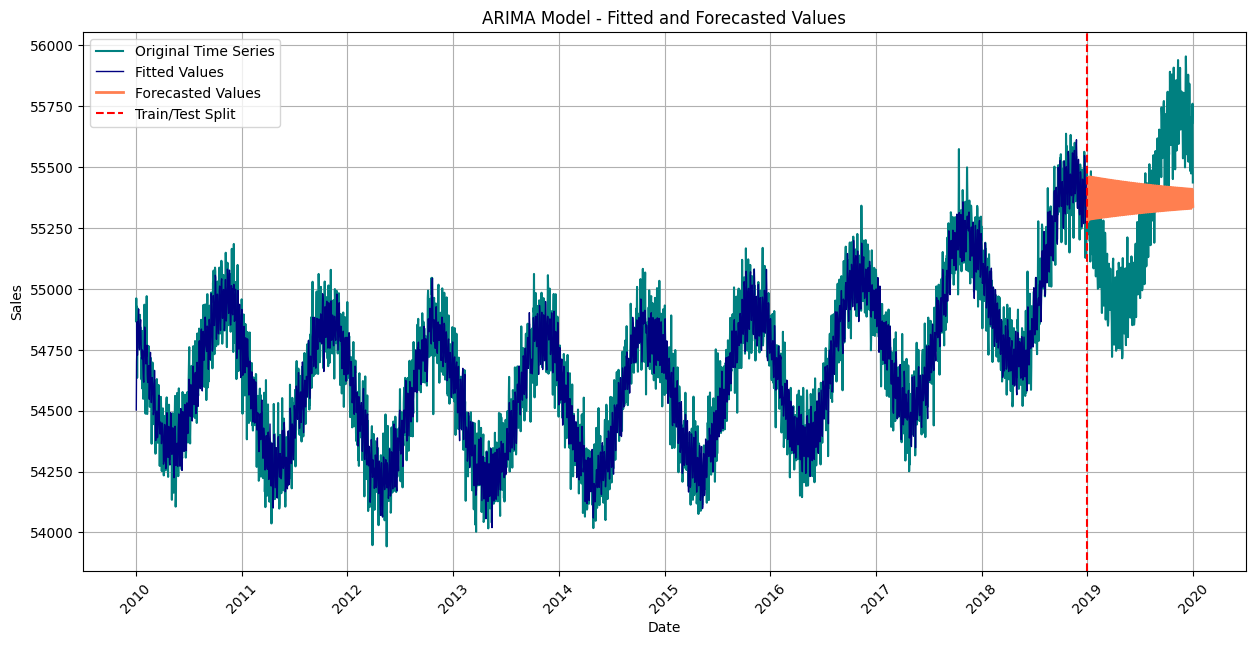

In [20]:
# Plot the results with transparency
plt.figure(figsize=(15, 7))
plt.plot(total_sales.index, total_sales, label='Original Time Series', color='teal')
plt.plot(train_predict_series.index, train_predict_series, label='Fitted Values', color='navy', linewidth=1)
plt.plot(predictions_series.index, predictions_series, label='Forecasted Values', color='coral', linewidth=2)
plt.axvline(train_data.index[-1], color='red', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title('ARIMA Model - Fitted and Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Evaluate the model

In [21]:
# Align lengths of train_data and train_predict_series
train_data_aligned = train_data[start_index:]

# Evaluate the model
# Mean Squared Error for training data
MSE_train = mean_squared_error(train_data_aligned, train_predict_series)
print('Mean Squared Error (MSE) of model Auto-ARIMA for trained data = ', MSE_train)

# Mean Absolute Error for training data
MAE_train = mean_absolute_error(train_data_aligned, train_predict_series)
print('Mean Absolute Error (MAE) of model Auto-ARIMA for trained data = ', MAE_train)

# Root Mean Squared Error for training data
RMSE_train = np.sqrt(MSE_train)
print('Root Mean Squared Error (RMSE) of model Auto-ARIMA for trained data = ', RMSE_train)

# Mean Squared Error for testing data
MSE_test = mean_squared_error(test_data, predictions_series)
print('Mean Squared Error (MSE) of model Auto-ARIMA for test data = ', MSE_test)

# Mean Absolute Error for testing data
MAE_test = mean_absolute_error(test_data, predictions_series)
print('Mean Absolute Error (MAE) of model Auto-ARIMA for test data = ', MAE_test)

# Root Mean Squared Error for testing data
RMSE_test = np.sqrt(MSE_test)
print('Root Mean Squared Error (RMSE) of model Auto-ARIMA for test data = ', RMSE_test)

Mean Squared Error (MSE) of model Auto-ARIMA for trained data =  8958.95447333655
Mean Absolute Error (MAE) of model Auto-ARIMA for trained data =  75.61368297315937
Root Mean Squared Error (RMSE) of model Auto-ARIMA for trained data =  94.65175367280075
Mean Squared Error (MSE) of model Auto-ARIMA for test data =  93175.08846786998
Mean Absolute Error (MAE) of model Auto-ARIMA for test data =  268.68439253701166
Root Mean Squared Error (RMSE) of model Auto-ARIMA for test data =  305.2459475044181
